In [ ]:
from google.colab import files

# Upload the zip file
uploaded = files.upload()

Saving Dataset.zip to Dataset.zip


In [ ]:
import zipfile
import os

# Specify the name of the uploaded zip file
zip_file_name = 'Dataset.zip'

# Specify the directory to extract to
extract_path = '/content/data'

# Create the target directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import cv2

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models, callbacks

import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve,recall_score
import pandas as pd
from keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV


import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
labels_dict = {
    'Happy': 0,
    'Not_Happy': 1
}

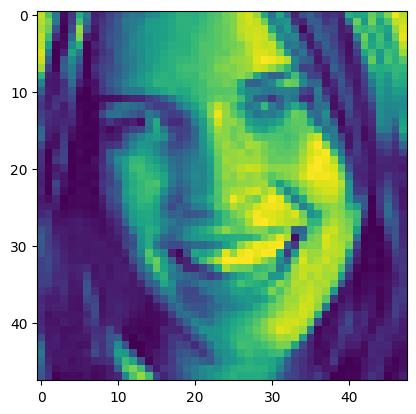

In [ ]:
# Normalizing image resize
directory = "/content/data/Training/Train/"
test_directory = "/content/data/Training/Test/"
classes=["Happy","Not_Happy"]
X,y ,resize_X,np_resize_X= [], [],[],[]
canny_img_X=[]
cat=[]




for category in classes:
  path= os.path.join(directory,category)
  for img_name in os.listdir(path):
    cat.append(labels_dict.get(category))
    y.append(labels_dict[category])
    img=cv2.imread(os.path.join(path,img_name))
    X.append(img)
    resize_img=cv2.resize(img, (48, 48))
    gray_image = cv2.cvtColor(resize_img, cv2.COLOR_BGR2GRAY)
    resize_img = gray_image/255.0
    np_resize_X.append(resize_img)

plt.imshow(np_resize_X[10])

In [ ]:
test_X,test_y ,test_resize_X,test_np_resize_X= [], [],[],[]
test_canny_img_X=[]

test_cat=[]
for category in classes:
  path= os.path.join(test_directory,category)
  for img_name in os.listdir(path):
    img=cv2.imread(os.path.join(path,img_name))
    if img is not None:
      test_cat.append(labels_dict.get(category))
      test_y.append(labels_dict[category])
      test_X.append(img)
      test_resize_img=cv2.resize(img, (48, 48))
      gray_image = cv2.cvtColor(test_resize_img, cv2.COLOR_BGR2GRAY)
      test_resize_img = gray_image/255.0
      test_np_resize_X.append(test_resize_img)

In [ ]:
import pandas as pd
dataFrame = pd.DataFrame()
dataFrame['img'] = X
dataFrame['cat'] = cat
dataFrame['class'] = y
dataFrame['np_normalize_img'] = np_resize_X
dataFrame = dataFrame.sample(frac=1).reset_index(drop=True)

test_dataFrame = pd.DataFrame()
test_dataFrame['img'] = test_X
test_dataFrame['cat'] = test_cat
test_dataFrame['class'] = test_y
test_dataFrame['np_normalize_img'] = test_np_resize_X
test_dataFrame = test_dataFrame.sample(frac=1).reset_index(drop=True)

dataFrame.head()


,img,cat,class,np_normalize_img
0,"[[[45, 45, 45], [42, 42, 42], [45, 45, 45], [3...",0,0,"[[0.17647058823529413, 0.16470588235294117, 0...."
1,"[[[1, 1, 1], [2, 2, 2], [2, 2, 2], [2, 2, 2], ...",1,1,"[[0.00392156862745098, 0.00784313725490196, 0...."
2,"[[[129, 129, 129], [123, 123, 123], [109, 109,...",1,1,"[[0.5058823529411764, 0.4823529411764706, 0.42..."
3,"[[[85, 85, 85], [83, 83, 83], [89, 89, 89], [8...",0,0,"[[0.3333333333333333, 0.3254901960784314, 0.34..."
4,"[[[40, 40, 40], [70, 70, 70], [106, 106, 106],...",0,0,"[[0.1568627450980392, 0.27450980392156865, 0.4..."


In [ ]:
# Select ratio
ratio = 0.80

total_rows = dataFrame.shape[0]
train_size = int(total_rows*ratio)

# Split data into test and train
train_ds = dataFrame[0:train_size]
validation_ds = dataFrame[train_size:]
print("train DF :"+ str(train_ds.shape[0]))
print("Validation DF :"+ str(validation_ds.shape[0]))

train DF :3217
Validation DF :805


In [ ]:
base_model = models.Sequential([
    layers.Conv2D(32, (3,3),  activation='relu',input_shape=(48,48,1)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3),  activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3) , activation='relu'),
])

base_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
Total params: 92672 (362.00 KB)
Trainable params: 92672 

In [ ]:
# Falten and Add dense layers
base_model.add(layers.Flatten())
base_model.add(layers.Dense(112, activation='relu'))
base_model.add(layers.Dense(2))

base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 8192)              0

In [ ]:
from tensorflow.keras import layers, models, callbacks
data_X = np.array(train_ds['np_normalize_img'].tolist())
data_y = np.array(train_ds['class'].tolist())
validate_X = np.array(validation_ds['np_normalize_img'].tolist())
validate_y = np.array(validation_ds['class'].tolist())
num_classes = 2



base_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
#early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Training the model
history_normal = base_model.fit(data_X, data_y,validation_data=(validate_X, validate_y), epochs=15)


Epoch 1/15
101/101 [==============================] - 17s 147ms/step - loss: 0.6875 - accuracy: 0.5362 - val_loss: 0.6774 - val_accuracy: 0.5938
Epoch 2/15
101/101 [==============================] - 15s 149ms/step - loss: 0.6273 - accuracy: 0.6487 - val_loss: 0.5786 - val_accuracy: 0.7019
Epoch 3/15
101/101 [==============================] - 16s 163ms/step - loss: 0.5352 - accuracy: 0.7380 - val_loss: 0.5139 - val_accuracy: 0.7602
Epoch 4/15
101/101 [==============================] - 15s 150ms/step - loss: 0.4708 - accuracy: 0.7749 - val_loss: 0.4637 - val_accuracy: 0.7988
Epoch 5/15
101/101 [==============================] - 14s 143ms/step - loss: 0.4195 - accuracy: 0.8076 - val_loss: 0.4236 - val_accuracy: 0.8000
Epoch 6/15
101/101 [==============================] - 15s 146ms/step - loss: 0.3773 - accuracy: 0.8281 - val_loss: 0.4067 - val_accuracy: 0.8050
Epoch 7/15
101/101 [==============================] - 14s 143ms/step - loss: 0.3359 - accuracy: 0.8539 - val_loss: 0.4176 - val_ac

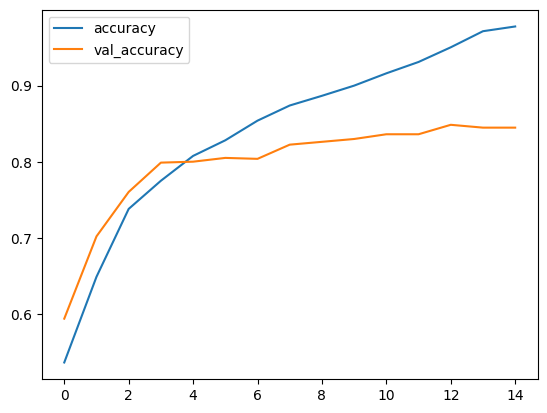

In [ ]:
# Plot training & validation loss values
plt.plot(history_normal.history['accuracy'], label='accuracy')
plt.plot(history_normal.history['val_accuracy'], label = 'val_accuracy')
plt.legend()

In [ ]:
# prompt: No module named 'keras.wrappers'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks


In [ ]:
!pip install --upgrade tensorflow scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 60.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0


In [ ]:

!pip install scikeras

In [ ]:
!pip install scikit-learn

In [ ]:
pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 1.4 MB/s eta 0:00:00


In [ ]:
def model_builder(hp):
   hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
   hp_dropout = hp.Choice('dropout', values=[0.2, 1e-3, 1e-4])
   model = models.Sequential([
             layers.experimental.preprocessing.RandomFlip("horizontal",input_shape=(48,48,1)),
             layers.experimental.preprocessing.RandomContrast(0.2),
             layers.experimental.preprocessing.RandomRotation(0.2),
             layers.Conv2D(
                filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
                kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
                activation='relu',input_shape=(48,48,1)
             ),
             layers.Conv2D(
                filters=hp.Int('conv_2_filter', min_value=32, max_value=512, step=16),
                kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
                activation='relu',input_shape=(48,48,1)
             ),
             layers.Conv2D(
                filters=hp.Int('conv_3_filter', min_value=32, max_value=512, step=16),
                kernel_size=hp.Choice('conv_3_kernel', values = [3,5]),
                activation='relu',input_shape=(48,48,1)
             ),
             layers.Flatten(),
             layers.Dense(units=hp.Int('conv_4_filter', min_value=32, max_value=128, step=16), activation='relu'),
             layers.Dense(2, activation='softmax')
      ])
   model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])
   return model

In [60]:
# prompt: delete folder

!rm -rf output


In [61]:
import keras_tuner as kt
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

tuner_search=RandomSearch(model_builder,
                          objective='val_accuracy',
                          max_trials=5,directory='output',project_name="Emotion Detection")

In [62]:
tuner_search.search(np.array(dataFrame['np_normalize_img'].tolist()), np.array(dataFrame['class'].tolist()), epochs=16, validation_split=0.2, callbacks=[stop_early])

Trial 5 Complete [00h 05m 29s]
val_accuracy: 0.5341615080833435

Best val_accuracy So Far: 0.8236024975776672
Total elapsed time: 01h 17m 43s


In [63]:
model=tuner_search.get_best_models(num_models=1)[0]

In [64]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 48, 48, 1)         0         
                                                                 
 random_contrast (RandomCon  (None, 48, 48, 1)         0         
 trast)                                                          
                                                                 
 random_rotation (RandomRot  (None, 48, 48, 1)         0         
 ation)                                                          
                                                                 
 conv2d (Conv2D)             (None, 44, 44, 64)        1664      
                                                                 
 dropout (Dropout)           (None, 44, 44, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 22, 22, 64)        0

In [67]:
history_tune=model.fit(np.array(dataFrame['np_normalize_img'].tolist()), np.array(dataFrame['class'].tolist()), epochs=16, validation_split=0.1, initial_epoch=3)

Epoch 4/16
114/114 [==============================] - 130s 1s/step - loss: 0.4089 - accuracy: 0.8121 - val_loss: 0.4085 - val_accuracy: 0.8288
Epoch 5/16
114/114 [==============================] - 124s 1s/step - loss: 0.3967 - accuracy: 0.8149 - val_loss: 0.4243 - val_accuracy: 0.8189
Epoch 6/16
114/114 [==============================] - 127s 1s/step - loss: 0.3910 - accuracy: 0.8151 - val_loss: 0.4039 - val_accuracy: 0.8213
Epoch 7/16
114/114 [==============================] - 126s 1s/step - loss: 0.3983 - accuracy: 0.8138 - val_loss: 0.4128 - val_accuracy: 0.8213
Epoch 8/16
114/114 [==============================] - 126s 1s/step - loss: 0.3753 - accuracy: 0.8331 - val_loss: 0.3909 - val_accuracy: 0.8114
Epoch 9/16
114/114 [==============================] - 124s 1s/step - loss: 0.3680 - accuracy: 0.8364 - val_loss: 0.3814 - val_accuracy: 0.8313
Epoch 10/16
114/114 [==============================] - 126s 1s/step - loss: 0.3561 - accuracy: 0.8372 - val_loss: 0.4253 - val_accuracy: 0.796

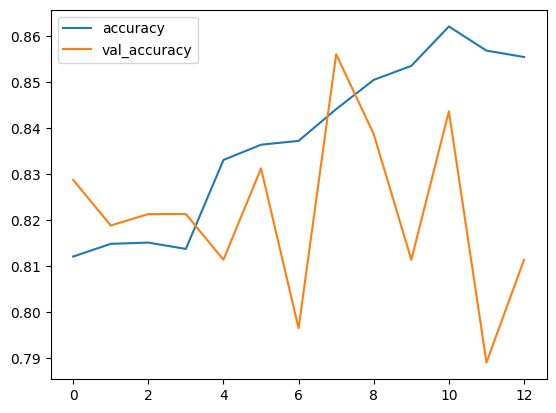

In [68]:
# Plot training & validation loss values
plt.plot(history_tune.history['accuracy'], label='accuracy')
plt.plot(history_tune.history['val_accuracy'], label = 'val_accuracy')
plt.legend()

In [69]:
test_X = np.array(test_dataFrame['np_normalize_img'].tolist())
test_y = np.array(test_dataFrame['class'].tolist())
model.evaluate(test_X,test_y)

14/14 [==============================] - 3s 214ms/step - loss: 0.3789 - accuracy: 0.8255


[0.37894877791404724, 0.8254716992378235]

In [70]:
def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))
    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['Happy', 'Not Happy'], yticklabels=['Happy', 'Not Happy'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [71]:
train_prediction_X = model.predict(test_X)
train_predicted_labels = np.argmax(train_prediction_X, axis=1)

14/14 [==============================] - 4s 252ms/step


              precision    recall  f1-score   support

           0       0.78      0.87      0.82       200
           1       0.87      0.79      0.83       224

    accuracy                           0.83       424
   macro avg       0.83      0.83      0.83       424
weighted avg       0.83      0.83      0.83       424



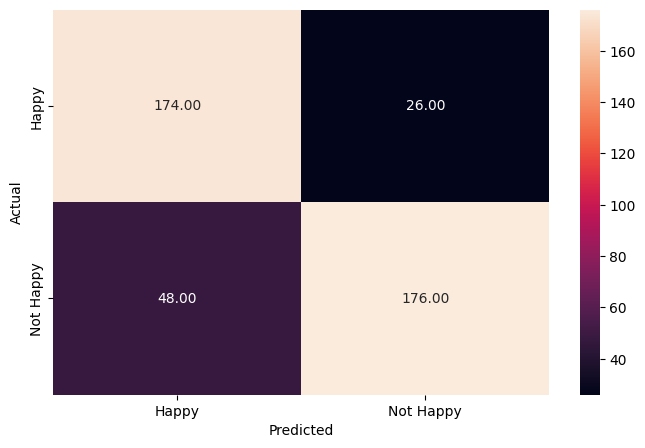

In [72]:
metrics_score(test_y, train_predicted_labels)

In [75]:
# prompt: convert milestone3-tuning.ipynb to html

!pip install nbconvert

In [77]:
/content/data

!jupyter nbconvert --to html  'milestone3-tunning.ipynb'

[NbConvertApp] WARNING | pattern 'milestone3-tunning.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--exec